Mean absolute error: 5.76
Mean squared error: 56.99
Root mean squared error: 7.55
R²: 0.8340287361986662


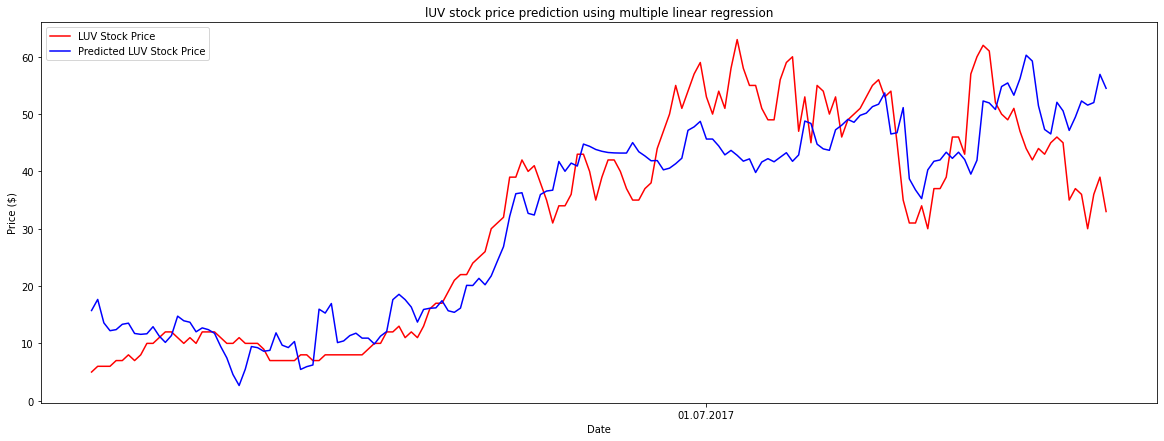

Mean absolute error: 2.06
Mean squared error: 6.65
Root mean squared error: 2.58
R²: 0.9806476175021657


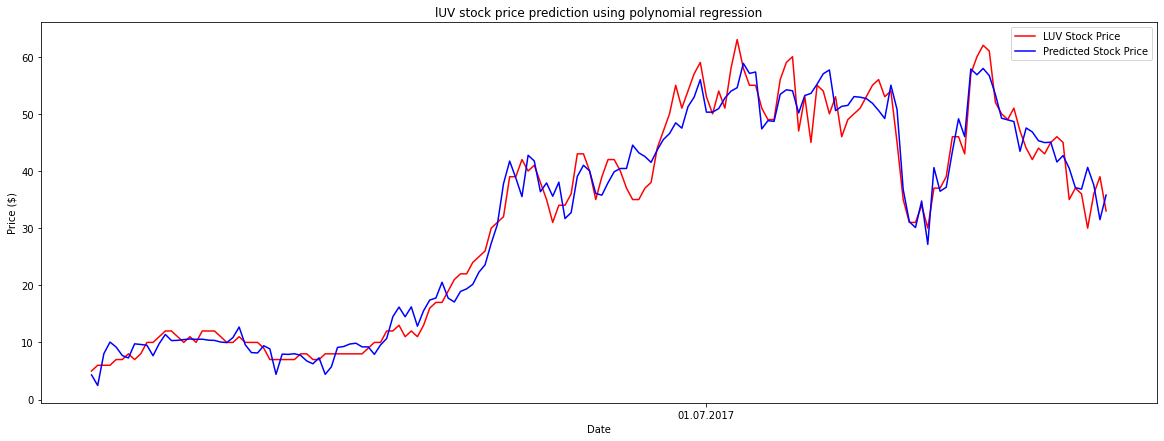

Epoch 1/100
3/3 [==============================] - 11s 132ms/step - loss: 0.4863
Epoch 2/100
3/3 [==============================] - 0s 128ms/step - loss: 0.2356
Epoch 3/100
3/3 [==============================] - 0s 124ms/step - loss: 0.0422
Epoch 4/100
3/3 [==============================] - 0s 128ms/step - loss: 0.0653
Epoch 5/100
3/3 [==============================] - 0s 138ms/step - loss: 0.0233
Epoch 6/100
3/3 [==============================] - 0s 124ms/step - loss: 0.0323
Epoch 7/100
3/3 [==============================] - 0s 126ms/step - loss: 0.0245
Epoch 8/100
3/3 [==============================] - 0s 120ms/step - loss: 0.0234
Epoch 9/100
3/3 [==============================] - 0s 120ms/step - loss: 0.0190
Epoch 10/100
3/3 [==============================] - 0s 124ms/step - loss: 0.0152
Epoch 11/100
3/3 [==============================] - 1s 198ms/step - loss: 0.0170
Epoch 12/100
3/3 [==============================] - 1s 197ms/step - loss: 0.0177
Epoch 13/100
3/3 [==================

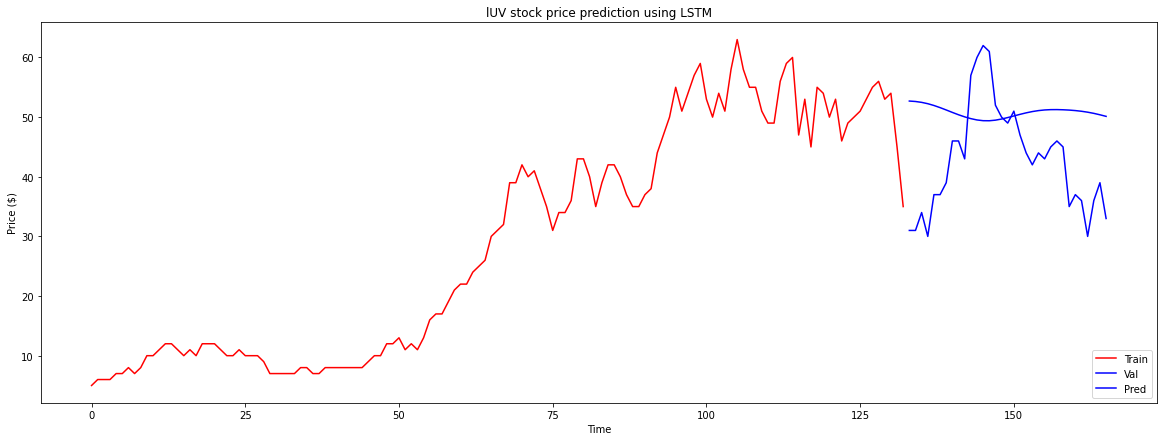

In [ ]:
#!/usr/bin/env python3
#Pet project по анализу цены акций компании Southwest Airlines(NYSE:LUV)
#от парсинга данных до визуализации результатов моделей
#протестированы модели:множественная линейная регрессия,полиномиальная регрессия,нейросеть LSTM
try: 
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf
import pandas as pd
import numpy as np

import time as t
import datetime as d
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
import math 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score
pd.options.mode.chained_assignment = None
####функции по обработке данных
#константы

BASE_DATE_FORMAT = '%Y-%m-%d'

LTDBC_DATA_RETRIEVAL_ERROR = 1  # Не удаось загрузить данные со страницы

GDBM_START_DATE_ERROR = 2
GDBM_END_DATE_ERROR = 3
GDBM_INPUT_PARAMS_NOT_STRING_TYPE = 10

FIDGID_INPUT_PARAMETER_ERROR = 5
FIDGID_NO_DATA_ERROR = 6

CDFFL_INPUT_PARAMETER_DATA_ERROR = 7
CDFFL_INPUT_PARAMETER_COLUMNS_ERROR = 8
CDFFL_COLUMNS_MISMATCH_ERROR = 9



# Генерирует диапазон дат с интервалом 1 месяц.
#
# Входные параметры:
# start (str) Начальная дата, формат: %Y-%m-%d (пример: 2022-09-30)
# end (str) Конечная дата,  формат: %Y-%m-%d (пример: 2022-09-30)
#
# Возвращает: <class 'list'> Список дат (пример: [2022-07-31, 2022-08-31, 2022-09-30])

def generateDatesByMonth(start, end):
   
    # Проверяем начальную дату (start)
    try:
        d.datetime.strptime(start, BASE_DATE_FORMAT)
    except ValueError:
        return GDBM_START_DATE_ERROR

    # Проверяем конечную дату (end)
    try:
        d.datetime.strptime(end, BASE_DATE_FORMAT)
    except ValueError:
        return GDBM_END_DATE_ERROR

    # Проверяем то, что начальная дата меньше, чем конечная,
    # если это не так, то исправляем.
    if t.strptime(start, BASE_DATE_FORMAT) >= t.strptime(end, BASE_DATE_FORMAT):
        start, end = end, start

    return pd.date_range(start=start, end=end, freq='M') \
        .strftime(BASE_DATE_FORMAT) \
        .tolist()


# Создает новый список на основе датафрейма, добавляя пропущенные даты.
#
# Входные параметры:
# dataframe (pandas.core.frame.DataFrame) Датафрейм
#
# Возвращает: <class 'list'> Список, основанный на обработке датафрейма.

def fillInDatesGapsInDataFrame(dataFrame):
    # Проверяем, что входной параметр является датафреймом.
    if not isinstance(dataFrame, pd.DataFrame):
        return FIDGID_INPUT_PARAMETER_ERROR

    if dataFrame.empty:
        return FIDGID_NO_DATA_ERROR

    data = []
    prevRow = None
    for i, row in dataFrame.iterrows():
        if prevRow is not None:
            dateDiff = generateDatesByMonth(row[0], prevRow[0])
            dateDiff.pop(0)

            for item in dateDiff[::-1]:
                data.append([item, prevRow[1]])

        prevRow = row

        if i == dataFrame.index[-1]:
            data.append([row[0], row[1]])

    return data


# Создает новый датафрейм на основании переданного списка с табличными данными.
#
# Входные параметры:
# data (list) Список с данными
# columns (list) Список столбцов
#
# Возвращает: <class 'pandas.core.frame.DataFrame'> Новый датафрейм.
def createDataFrameFromList(data, columns):
    # Проверяем входной параметр с данными.
    if not isinstance(data, list) or not len(data):
        return CDFFL_INPUT_PARAMETER_DATA_ERROR

    # Проверяем входной параметр с описанием столбцов.
    if not isinstance(columns, list) or not len(columns):
        return CDFFL_INPUT_PARAMETER_COLUMNS_ERROR

    # Количество столбцов в списке с данными должно быть ровно
    # количеству элементов в списке с описанием столбцов
    if len(data[0]) != len(columns):
        return CDFFL_COLUMNS_MISMATCH_ERROR

    return pd.DataFrame(data=data, columns=columns)

### Данные по цене акций
luv = yf.Ticker("LUV")
stock_hist = luv.history(start="2009-03-01", end="2022-12-31", 
                  interval='1mo', actions=False)

# Создаем датафрейм на основе данных, полученных выше.
stockprice = pd.DataFrame(stock_hist) 
# Добавляем колонку с индексом (0, 1, 2 ..., N).
stockprice = stockprice.reset_index() 
# Удаляем ненужные столбцы.
stockprice = stockprice.drop(columns=['Open','High','Low','Volume'])
# Форматируем колонку с датами (оставляем только год и месяц).
stockprice['Date'] = stockprice['Date'].map(lambda x: pd.Period(x,'M'))
# Удаляем дробную часть цены в колонке "Close" (Например, было: "51.959999", стало: "51").
stockprice['Close'] = stockprice['Close'].astype('int64') 
# Сортируем датафрейм по колонке "Date".
stockprice = stockprice.sort_values(by='Date')
# Переименовываем колонку "Close" в "Stock_price".
stockprice = stockprice.rename(columns={'Close': 'Stock_price'})

#визуализация


#данные по snp500
snp = yf.Ticker("SPY")
snp500_hist = snp.history(start="2009-03-01", end="2022-12-31", 
                  interval='1mo', actions=False)
# Создаем датафрейм на основе данных, полученных выше.
snp500 = pd.DataFrame(snp500_hist) 
# Добавляем колонку с индексом (0, 1, 2 ..., N).
snp500 = snp500.reset_index() 
# Удаляем ненужные столбцы.
snp500 = snp500.drop(columns=['Open','High','Low','Volume'])
# Форматируем колонку с датами (оставляем только год и месяц).
snp500['Date'] = snp500['Date'].map(lambda x: pd.Period(x,'M'))
# Удаляем дробную часть цены в колонке "Close" (Например, было: "51.959999", стало: "51").
snp500['Close'] = snp500['Close'].astype('int64') 
# Сортируем датафрейм по колонке "Date".
snp500 = snp500.sort_values(by='Date')
# Переименовываем колонку "Close" в "snp500".
snp500 = snp500.rename(columns={'Close': 'snp500'})

## Получение данных по марке брент с тикера за указанный период.
cl = yf.Ticker("BZ=F")
cl.history(period = 'max', actions=False)
brent_hist = cl.history(start="2009-03-01", end="2022-12-31", interval='1mo', actions=False)
# Создаем датафрейм на основе данных, полученных выше.
brent = pd.DataFrame(brent_hist)
# Добавляем колонку с индексом (0, 1, 2 ..., N).
brent = brent.reset_index()
# Удаляем ненужные столбцы.
brent = brent.drop(columns=['Open', 'High', 'Low', 'Volume'])
# Форматируем колонку с датами (оставляем только год и месяц).
brent['Date'] = brent['Date'].map(lambda x: pd.Period(x, 'M').strftime(BASE_DATE_FORMAT))
# Удаляем дробную часть цены в колонке "Close" (Например, было: "51.959999", стало: "51").
brent['Close'] = brent['Close'].astype('int32')
# Сортируем датафрейм по колонке "Date".
brent = brent.sort_values(by='Date', ascending=False)
# Переименовываем колонку "Close" в "brent".
brent = brent.rename(columns={'Close': 'brent'})
# Генерируем данные для нового фрейма в котором не будет пропуска дат.
dataForNewDF1 = fillInDatesGapsInDataFrame(dataFrame=brent)

if isinstance(dataForNewDF1, int) and dataForNewDF1 == FIDGID_NO_DATA_ERROR:
    quit(f'Не удалось обработать датафрейм, отсутствуют данные для обработки.')

# Создаем результирующий датафрейм из данных, полученных на предыдущем этапе.
brentdata = createDataFrameFromList(data=dataForNewDF1,columns=['Date', 'brent'])

# Если есть ошибки, сообщаем о них.
if isinstance(brentdata, int):
    if brentdata == CDFFL_INPUT_PARAMETER_DATA_ERROR:
        quit('Недопустимый параметр "data".')

    if brentdata == CDFFL_INPUT_PARAMETER_COLUMNS_ERROR:
        quit('Недопустимый параметр "columns".')

    if brentdata == CDFFL_COLUMNS_MISMATCH_ERROR:
        quit('Количество столбцов в списке с данными должно быть ровно '
             'количеству элементов в списке с описанием столбцов.')

# Выводим на экран получившийся датафрейм.
pd.set_option('display.max_rows', None)
#по каким-то причинам нет данных за 2009-03-30,добавим вручную
lastadd = {'Date':' 2009-03-30','brent':'51',}
brentdata = brentdata.append(lastadd, ignore_index=True)
#переведем Date в формат datetime с периодом месяц(М)
brentdata["Date"] = pd.to_datetime(brentdata["Date"])
brentdata["Date"] = brentdata["Date"].dt.to_period("M")

###Добавляем данные по выручки и прибыли компани
##данные по выручке
PARSING_PAGE_URL = 'https://www.macrotrends.net/stocks/charts/LUV/southwest-airlines/revenue'
TABLE_CAPTION = 'Southwest Airlines Quarterly Revenue'

# Пытаемся прочитать данные из таблицы
try:
    df1 = pd.read_html(io=PARSING_PAGE_URL, match=TABLE_CAPTION)
except ValueError:
    quit(f'Не удалось найти таблицу с искомым заголовком = "{TABLE_CAPTION}"')

# Должна быть найдена только одна таблица
if (len(df1) != 1):
    quit(f'Недопустимое число найденных таблиц, необходима 1 таблица, найдено - {len(df1)}')

#генерация данных с квартальных помесячные с дубляжом
dataForNewDF2 = fillInDatesGapsInDataFrame(dataFrame=df1[0])
revenuedata = createDataFrameFromList(data=dataForNewDF2,columns=['Date', 'revenue'])
#убираем значек $
revenuedata = revenuedata.replace({'\$':''}, regex = True)
#делаем сортировку по дате
revenuedata = revenuedata.sort_values(by='Date')
#приводим столбец Date к месячному
revenuedata['Date'] = revenuedata['Date'].map(lambda x: pd.Period(x,'M'))

## получаем данные по прибыли
PARSING_PAGE_URL1 = 'https://www.macrotrends.net/stocks/charts/LUV/southwest-airlines/net-income'
TABLE_CAPTION1 = 'Southwest Airlines Quarterly Net Income'

# Пытаемся прочитать данные из таблицы
try:
    df2 = pd.read_html(io=PARSING_PAGE_URL1, match=TABLE_CAPTION1)
except ValueError:
    quit(f'Не удалось найти таблицу с искомым заголовком = "{TABLE_CAPTION1}"')

# Должна быть найдена только одна таблица
if (len(df1) != 1):
    quit(f'Недопустимое число найденных таблиц, необходима 1 таблица, найдено - {len(df1)}')

##генерация данных с квартальных помесячные с дубляжом
dataForNewDF3 = fillInDatesGapsInDataFrame(dataFrame=df2[0])
netincomedata = createDataFrameFromList(data=dataForNewDF3,columns=['Date', 'net income'])
#убираем значек $
netincomedata = netincomedata.replace({'\$':''}, regex = True)
#делаем сортировку по дате
netincomedata = netincomedata.sort_values(by='Date')
#приводим столбец Date к месячному
netincomedata['Date'] = netincomedata['Date'].map(lambda x: pd.Period(x,'M'))


###соединеняем данные по цене акций,выручке,прибыли,цене на нефть в результатирующий df
result = stockprice.merge(revenuedata,how = 'inner',on ='Date').merge(netincomedata,on ='Date').merge(brentdata,on ='Date').merge(snp500,on ='Date')
#сохраняем в excel
result.to_csv('PythonExport.csv', sep=',')
#посмтрим корреляцию
#для работы с данными требуеться тип данных int провели переобразование
result['revenue'] = result['revenue'].str.replace(',', '').astype(float)
result['revenue'] = result['revenue'].astype('int32')
result['net income'] = result['net income'].str.replace(',', '').astype(float)
result['net income'] = result['net income'].astype('int32')
result['brent'] = result['brent'].astype('int32')
result['snp500'] = result['snp500'].astype('int32')

###кореляция
#построим корреляционную матрицу
#df_plot = sns.heatmap(result.corr(), cmap="YlGnBu", annot=True)  
#plt.show()
##По результату видим,что найбольшая корреляция с индексом snp500 оно обьясняет 75% цены акций,на 57% цена на нефть с отрицательной корреляций,на 46% выручка


##построим модель множественной линейная регрессии
# в X как обьясняющие переменные добавим выручку,нефть,индекс а Y как зависимая переменная цена акций
X = result[['revenue','brent','snp500']]
y = result['Stock_price']
#Теперь необходимо разделить набор данных для обучения и тестирования регрессионной модели (80% тренировочная 20% тестовая)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)
#инициализирум регрессию можно подогнать модель для прогнозирования значений
regressor = LinearRegression()
regressor.fit(X_train, y_train)

#посмтрим на уравнение регрессии
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
 #print(coeff_df)
 #print(regressor.intercept_)

y_ = np.array(result['Stock_price'])
x_ = np.array(result[['revenue','brent','snp500']])

#уравнение регрессии имеет вид Y = 14.75+0.004846*revenue -0.319317*brent+0.097300*snp500
#прогнозируем на нашей тестовой выборке
y_pred = regressor.predict(X_test)
res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

##расчитываем метрики
#(mean absolute error, средняя абсолютная ошибка) — позволяет узнать разницу между фактическими и прогнозируемыми значениями
mae = mean_absolute_error(y_test, y_pred)
# mse можно рассматривать как уточненную MAE, поскольку она помогает находить ошибки с помощью квадратичной разницы между фактическими и прогнозируемыми значениями
mse = mean_squared_error(y_test, y_pred)
#rmse показывает разницу между фактическими и прогнозируемыми значениями, извлекая корень квадратный из средней квадратичной ошибки
rmse = np.sqrt(mse)
#R2 для определения доли вариаций зависимой переменной, что прогнозируется по независимой переменной
actual_minus_predicted = sum((y_test - y_pred)**2)
actual_minus_actual_mean = sum((y_test - y_test.mean())**2)
r2 = 1 - actual_minus_predicted/actual_minus_actual_mean
#результаты
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print('R²:', r2)
#Имеем:Mean absolute error: 5.76,Mean squared error: 56.99,Root mean squared error: 7.55,R²: 0.8340287361986662
#также выведем сводную метрику по цене акций
 #print(result['Stock_price'].describe())
#по результату можно сказать:модель обьясняет 83% поведения цены акций,остальные 17% не учитывает. Исходя из MAE и RMSE ошибки незначительные 5,75 и 7,55 что ниже чем стандартное отклонение 18
##проверим нет ли переобучения
 #print(regressor.score(X_test, y_test))
 #print(regressor.score(X_train, y_train))
#по результату видим,что модель обьясняет 83% данных на тестовой выборке и 81% на тренировочной,что нормально
###визализация
result['Date'] = result['Date'].dt.to_timestamp('s').dt.strftime('%d.%m.%Y')
plt.figure(figsize=(20,7))
plt.plot(result['Date'].values, result['Stock_price'].values, label = 'LUV Stock Price', color = 'red')
plt.plot(result['Date'].values, regressor.predict(X), color='blue',label = 'Predicted LUV Stock Price')
plt.xticks(np.arange(100,result.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('lUV stock price prediction using multiple linear regression')
plt.legend()
plt.show()

##полиномиальная регрессия
#это инструмент преобразования, который преобразует матрицу признаков X в новую матрицу признаков X_poly.был выбран полином 4 степени
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

y_pred2 = pol_reg.predict(poly_reg.fit_transform(X_test))
res2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred2})

##расчитываем метрики
#(mean absolute error, средняя абсолютная ошибка) — позволяет узнать разницу между фактическими и прогнозируемыми значениями
mae = mean_absolute_error(y_test, y_pred2)
# mse можно рассматривать как уточненную MAE, поскольку она помогает находить ошибки с помощью квадратичной разницы между фактическими и прогнозируемыми значениями
mse = mean_squared_error(y_test, y_pred2)
#rmse показывает разницу между фактическими и прогнозируемыми значениями, извлекая корень квадратный из средней квадратичной ошибки
rmse = np.sqrt(mse)
#R2 для определения доли вариаций зависимой переменной, что прогнозируется по независимой переменной
actual_minus_predicted1 = sum((y_test - y_pred2)**2)
actual_minus_actual_mean1 = sum((y_test - y_test.mean())**2)
r2 = 1 - actual_minus_predicted1/actual_minus_actual_mean1
#результаты
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print('R²:', r2)
###визализация
#result['Date'] = result['Date'].dt.to_timestamp('s').dt.strftime('%d.%m.%Y')
plt.figure(figsize=(20,7))
plt.plot(result['Date'].values, result['Stock_price'].values, label = 'LUV Stock Price', color = 'red')
plt.plot(result['Date'].values, pol_reg.predict(poly_reg.fit_transform(X)), color='blue',label = 'Predicted Stock Price')
plt.xticks(np.arange(100,result.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('lUV stock price prediction using polynomial regression')
plt.legend()
plt.show()
#Имеем: Mean absolute error: 2.06, Mean squared error: 6.65, Root mean squared error: 2.58, R²: 0.980647617502165
#По результату можно сказать:полиномиальная модель обьясняет 98% поведения цены акций,остальные 2% не учитывает. 
#Исходя из MAE и RMSE ошибки уменьшились по сравнению с линейной моделью.
#Обычно у полиномиальной регрессии есть серьезная проблема — мультиколлинеарность,что потребует доп.анализа


#####lstm
# Создаем новый датафрейм только с колонкой "Stock_price"
data = result.filter(['Stock_price'])
# преобразовываем в нумпаевский массив
dataset = data.values
# Вытаскиваем количество строк в дате для обучения модели (LSTM)
training_data_len = math.ceil(len(dataset) * .8)
#Scale the data (масштабируем)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset) 
# Создаем датасет для обучения
train_data = scaled_data[0:training_data_len]
# разбиваем на x underscore train и y underscore train 
x_train3 = []
y_train3 = []
for i in range(60, len(train_data)):
    x_train3.append(train_data[i-60:i])
    y_train3.append(train_data[i])
#Конвертируем x_train и y_train в нумпаевский массив
x_train3, y_train3 = np.array(x_train3), np.array(y_train3)
#Reshape data
x_train3 = np.reshape(x_train3, (x_train3.shape[0],x_train3.shape[1],x_train3.shape[2]))
#Строим нейронку
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train3.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
#компелируем модель.
#batch_size -какое количество выборки берет алгоритм из обучающего набора данных и обучает сеть.
#epoch- один прямой проход и один обратный проход всех обучающих примеро
#Выбрали оптимизатор "adam" и mean square error как функцию потерь
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(x_train3, y_train3, epochs = 100, batch_size = 32)
#Создаем тестовый датасет
test_data = scaled_data[training_data_len - 60:]
#по аналогии создаем x_test и y_test 
x_test3 = []
y_test3 = dataset[training_data_len:]
for i in range(60,len(test_data)):
    x_test3.append(test_data[i-60:i])
#опять преобразуем в нумпаевский массив
x_test3 = np.array(x_test3)
#опять делаем reshape
x_test3 = np.reshape(x_test3,(x_test3.shape[0],x_test3.shape[1],x_test3.shape[2]))
#Получаем модель предсказывающую значения
predictions = regressor.predict(x_test3)
predictions = scaler.inverse_transform(predictions)
##расчитываем метрики
#(mean absolute error, средняя абсолютная ошибка) — позволяет узнать разницу между фактическими и прогнозируемыми значениями
mae = mean_absolute_error(y_test3, predictions)
# mse можно рассматривать как уточненную MAE, поскольку она помогает находить ошибки с помощью квадратичной разницы между фактическими и прогнозируемыми значениями
mse = mean_squared_error(y_test3, predictions)
#rmse показывает разницу между фактическими и прогнозируемыми значениями, извлекая корень квадратный из средней квадратичной ошибки
rmse = np.sqrt(mse)
#результаты
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
#Строим график
train = data[:training_data_len]
valid = data[training_data_len:]
valid.loc[:, "Predictions"] = predictions

#Визуализируем
plt.figure(figsize=(20,7))
plt.plot(train['Stock_price'], color = 'red', label = 'LUV Stock Price')
plt.plot(valid[['Stock_price','Predictions']], color = 'blue', label = 'Predicted Stock Price')
plt.title('lUV stock price prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend(['Train','Val','Pred'], loc = 'lower right')
plt.show()

#В итоге, видим,что модель LSTM по метрикам и наглядно продемонстрировала худшие результаты,по сравнению с предыдущими моделями. 
#Одна из наиболее вероятных причин это в отстутвии обьясняющих переменных в случае с линейной и полиноминальной мы использовали нефть,индекс,выручку,а в случае LSTM использовали только цену акций.
#На результаты также оказывает влияние размер выборки и выбор геперпараметров епохи,batch-size и т.д.
